In [133]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.solvers import MathematicalProgram, Solve, GetAvailableSolvers, GetProgramType, MosekSolver, IpoptSolver
from pydrake.all import eq, ge, le
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle, Circle
from IPython.display import HTML, display

In [134]:
# without stepping stones, this is a convex QCQP, or SOCP
'''
    QCQP:
    =====
    minimize x^T Q x = cost-to-go
    subject to:
    -> step limits
    -> reachability
    -> force alternation between feet
    -> boundary conditions (initial, final)
'''

def freespace_footstep_qcqp(initial_left, initial_right, goal_pos, n_steps, step_span, foot_reach, feet_gap = 0.05):
    
    prog = MathematicalProgram()
    
    # decision variables
    left_feet = prog.NewContinuousVariables(2, n_steps, "left_feet")
    right_feet = prog.NewContinuousVariables(2, n_steps, "right_feet")
    
    # footstep limits and force alternation
    # foot_i - foot_{i-1} \in [-step_span, step_span]
    for i in range(1, n_steps):
        # for even i, left foot is moving
        # for odd i, right foot is moving
        
        if i % 2 == 0:
            prog.AddLinearConstraint(le(left_feet[:, i] - left_feet[:, i-1], np.ones(2) * step_span))
            prog.AddLinearConstraint(ge(left_feet[:, i] - left_feet[:, i-1], -np.ones(2) * step_span))
            
            prog.AddLinearConstraint(eq(right_feet[:, i] - right_feet[:, i-1], np.zeros(2)))
        else:
            prog.AddLinearConstraint(le(right_feet[:, i] - right_feet[:, i-1], np.ones(2) * step_span))
            prog.AddLinearConstraint(ge(right_feet[:, i] - right_feet[:, i-1], -np.ones(2) * step_span))
            
            prog.AddLinearConstraint(eq(left_feet[:, i] - left_feet[:, i-1], np.zeros(2)))
    
    # reachability
    # foot_i - foot_i-1 inside circle of radius foot_reach
    for i in range(1, n_steps):
        # (foot_i - foot_i-1)^T (foot_i - foot_i-1) <= foot_reach^2
        # make sure left foot is within reach of previous left and right feet
        prog.AddQuadraticConstraint((left_feet[:, i] - left_feet[:, i-1]).T @ (left_feet[:, i] - left_feet[:, i-1]), lb=-np.inf, ub=foot_reach**2)
        prog.AddQuadraticConstraint((left_feet[:, i] - right_feet[:, i-1]).T @ (left_feet[:, i] - right_feet[:, i-1]), lb=-np.inf, ub=foot_reach**2)
        
        prog.AddQuadraticConstraint((right_feet[:, i] - right_feet[:, i-1]).T @ (right_feet[:, i] - right_feet[:, i-1]), lb=-np.inf, ub=foot_reach**2)
        prog.AddQuadraticConstraint((right_feet[:, i] - left_feet[:, i-1]).T @ (right_feet[:, i] - left_feet[:, i-1]), lb=-np.inf, ub=foot_reach**2)
        
        
    for i in range(n_steps):
        prog.AddQuadraticConstraint((left_feet[:, i] - right_feet[:, i]).T @ (left_feet[:, i] - right_feet[:, i]), lb=feet_gap**2, ub=np.inf)
        
        
    
    #boundary conditions
    # initial and final foot positions
    prog.AddLinearConstraint(eq(left_feet[:, 0], initial_left))
    prog.AddLinearConstraint(eq(right_feet[:, 0] ,initial_right))
    
    # add quadratic cost (make sure feet are close to goal)
    Q = np.eye(2)
    for i in range(n_steps):
        prog.AddQuadraticCost((left_feet[:, i] - goal_pos).T @ Q @ (left_feet[:, i] - goal_pos), is_convex=True)
        prog.AddQuadraticCost((right_feet[:, i] - goal_pos).T @ Q @ (right_feet[:, i] - goal_pos), is_convex=True)
    
    # check solver type
    print(GetProgramType(prog))
    print([solver.name() for solver in GetAvailableSolvers(GetProgramType(prog))])
    
    # intitalize guess
    # linear interpolate from left foot to goal
    # linear interpolate from right foot to goal
    for i in range(n_steps):
        prog.SetInitialGuess(left_feet[:, i], initial_left + i/n_steps * (goal_pos - initial_left))
        prog.SetInitialGuess(right_feet[:, i], initial_right + i/n_steps * (goal_pos - initial_right))
    result = Solve(prog)
    
    if result.is_success():
        print("Success")
        print(result.get_solution_result())
    else:
        print("Failed")
    
    return_left = result.GetSolution(left_feet)
    return_right = result.GetSolution(right_feet)
    
    return return_left, return_right

In [135]:
initial_left = np.array([0, -0.1])
initial_right = np.array([0, 0.1])

goal_pos = np.array([2, 0])
n_steps = 30
step_span = 0.2
foot_reach = 0.2
feet_gap = 0.2

left, right = freespace_footstep_qcqp(initial_left, initial_right, goal_pos, n_steps, step_span, foot_reach, feet_gap=feet_gap)

ProgramType.kNLP
['SNOPT', 'IPOPT', 'NLopt']
Success
SolutionResult.kSolutionFound


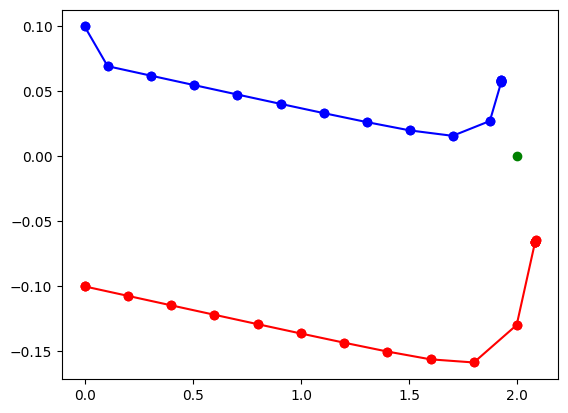

In [136]:
# plot the footstep sequence
plt.plot(initial_left[0], initial_left[1], 'ro')
plt.plot(initial_right[0], initial_right[1], 'bo')
plt.plot(left[0, :], left[1, :], 'ro-'
         , right[0, :], right[1, :], 'bo-')
plt.plot(goal_pos[0], goal_pos[1], 'go')
plt.show()

In [137]:
def animate_footstep_plan(left_feet, right_feet, step_span):
    fix, ax = plt.subplots()
    
    left_foot0 = left_feet[:, 0]
    right_foot0 = right_feet[:, 0]
    
    left_foot = ax.scatter(left_foot0[0], left_foot0[1], c='r', zorder=3, label='Left Foot')
    right_foot = ax.scatter(right_foot0[0], right_foot0[1], c='b', zorder=3, label='Right Foot')
    
    #plot step limit visualized as circle
    step_limit_left = plt.Circle((left_foot0[0], left_foot0[1]), step_span, color='r', fill=False)
    step_limit_right = plt.Circle((right_foot0[0], right_foot0[1]), step_span, color='b', fill=False)
    
    #draw circle
    ax.add_patch(step_limit_left)
    ax.add_patch(step_limit_right)
    
    plt.close()
    ax.legend(loc="upper left", bbox_to_anchor=(0, 1.3), ncol=2)
    # set limits depending on feet position
    ax.set_xlim([min(left_feet[0, :]) - step_span, max(right_feet[0, :]) + step_span])
    ax.set_ylim([min(left_feet[1, :]) - step_span, max(right_feet[1, :]) + step_span])
    # make sure x-axis and y-axis are scaled equally
    ax.set_aspect('equal', adjustable='box')
    
    def animate(n_steps):
        left_foot.set_offsets(left_feet[:, n_steps])
        right_foot.set_offsets(right_feet[:, n_steps])
        
        #update circle
        step_limit_left.center = (left_feet[0, n_steps], left_feet[1, n_steps])
        step_limit_right.center = (right_feet[0, n_steps], right_feet[1, n_steps])
    ani = FuncAnimation(fix, animate, frames=range(left_feet.shape[1]), repeat=False)
    display(HTML(ani.to_jshtml()))

In [138]:
animate_footstep_plan(left, right, step_span)

In [1]:
from pydrake.all import PiecewisePolynomial, ZmpPlanner

ImportError: cannot import name 'ZmpPlanner' from 'pydrake.all' (/home/andang/.local/lib/python3.10/site-packages/pydrake/all.py)

In [ ]:
# develop a desired ZMP trajectory using first order hold
def zmp_desired_generate(left_feet, right_feet, double_support_time, single_support_time):
    
    # get footsteps
    # assume right feet move first
    footsteps = []
    for i in range(left_feet.shape[1]):
        footsteps.append(right_feet[:, i])
        footsteps.append(left_feet[:, i])
    
    footsteps = np.array(footsteps).T # shape (2, 2*n_steps)
    
    zmp_d = []
    time_steps = []
    